In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn

from PIL import Image

import os, time, copy

import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import v2


In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
num_classes = 10
num_epochs = 20
batch_size = 32
learning_rate = 0.001
patience = 5

Using cuda device


# **Xử lí data**

In [3]:
data_dir = "/kaggle/input/handwritten-tl/digits_data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

In [4]:
data_transforms = {
    'train': v2.Compose([
        v2.Resize((224, 224)),
        v2.RandomRotation(10),
        v2.RandomAffine(0, translate=(0.1,0.1)),
        v2.RandomHorizontalFlip(),
        v2.CenterCrop(200),
        v2.ToTensor(),
        v2.Grayscale(num_output_channels=3),
        v2.Normalize(mean=[0.485,0.456,0.406],
                std =[0.229,0.224,0.225]),
    ]),
    'val': v2.Compose([
        v2.Resize(224),
        v2.CenterCrop(200),
        v2.ToTensor(),
        v2.Grayscale(num_output_channels=3),
        v2.Normalize(mean=[0.485,0.456,0.406],
                std =[0.229,0.224,0.225]),
    ]),
}

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, transform=data_transforms['val']),
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x=='train'), num_workers=2)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


# **Transfer learning**

In [6]:
model = models.vgg16(weights="VGG16_Weights.DEFAULT")
in_feats = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(in_feats, 10)
)
model = model.to(device)

# loss, optim, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 235MB/s]


In [7]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable params count: {num_trainable_params}")

Trainable params count: 134301514


In [8]:
# training
import time
start = time.time()
best_acc, patience_cnt = 0.0, 0
for e in range(num_epochs):
    print(f"Epoch: {e}", end="")
    e_start = time.time()
    # train
    model.train()
    running_loss = 0.0
    for imgs, labels in dataloaders["train"]:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outs = model(imgs)
        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*labels.size(0)
    train_loss = running_loss / dataset_sizes["train"]


    # validate
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for imgs, labels in dataloaders['val']:
            imgs, labels = imgs.to(device), labels.to(device)
            outs = model(imgs)
            loss = criterion(outs, labels)
            val_loss += loss.item() * labels.size(0)
            pred = outs.argmax(1)
            correct += (pred == labels).sum().item()
    val_loss /= dataset_sizes['val']
    val_acc = correct / dataset_sizes['val']

    # scheduler, print
    scheduler.step(val_loss)
    print(f", train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, val_acc={val_acc:.3f}, time: {(time.time()-e_start):.0f}s")

    # early stop
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        patience_cnt = 0
    else:
        patience_cnt += 1 
        if patience_cnt > patience:
            print("\n** Early Stop **\n")
            break
total_time = time.time() - start
print(f"Training time: {total_time//60}m {total_time%60:.2f}s")

Epoch: 0, train_loss=1.055, val_loss=0.539, val_acc=0.860, time: 164s
Epoch: 1, train_loss=0.420, val_loss=0.427, val_acc=0.892, time: 153s
Epoch: 2, train_loss=0.279, val_loss=0.374, val_acc=0.911, time: 153s
Epoch: 3, train_loss=0.234, val_loss=0.334, val_acc=0.912, time: 157s
Epoch: 4, train_loss=0.263, val_loss=0.339, val_acc=0.931, time: 154s
Epoch: 5, train_loss=0.177, val_loss=0.343, val_acc=0.934, time: 154s
Epoch: 6, train_loss=0.152, val_loss=0.304, val_acc=0.937, time: 152s
Epoch: 7, train_loss=0.133, val_loss=0.282, val_acc=0.937, time: 156s
Epoch: 8, train_loss=0.104, val_loss=0.297, val_acc=0.929, time: 155s
Epoch: 9, train_loss=0.148, val_loss=0.297, val_acc=0.925, time: 157s
Epoch: 10, train_loss=0.104, val_loss=0.270, val_acc=0.933, time: 153s
Epoch: 11, train_loss=0.089, val_loss=0.350, val_acc=0.937, time: 154s
Epoch: 12, train_loss=0.124, val_loss=0.376, val_acc=0.940, time: 153s
Epoch: 13, train_loss=0.070, val_loss=0.260, val_acc=0.940, time: 155s
Epoch: 14, train

# **Predict 2K**

In [9]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from tqdm import tqdm

class TestImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = sorted([
            os.path.join(image_dir, fname)
            for fname in os.listdir(image_dir)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image_path

In [10]:
test_dir = '/kaggle/input/handwritten-test-cs114'
testset = TestImageDataset(test_dir, transform=data_transforms['val'])
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
print(f"Samples num: {len(testset)}")

predict_txt = ""
paths = testset.image_paths  # ✅ Đúng cú pháp cho custom Dataset

predicted = []

with torch.no_grad():
    for inputs, _ in tqdm(testloader, desc="Predicting"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        predicted.extend(preds.cpu())

for path, pred in zip(paths, predicted):
    path = path.replace(test_dir, "").lstrip(os.sep)
    predict_txt += f"{path},{pred.item()}\n"

with open("/kaggle/working/predict_2k.txt", "w") as file:
    file.write(predict_txt)

print("🟢 Predictions saved in 'predict_2k.txt'")


Samples num: 2898


Predicting: 100%|██████████| 91/91 [00:43<00:00,  2.08it/s]

🟢 Predictions saved in 'predict_2k.txt'


# **Predict 10k**

In [11]:
test_dir = '/kaggle/input/handwritten-test-10k'
testset = TestImageDataset(test_dir, transform=data_transforms['val'])
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
print(f"Samples num: {len(testset)}")

predict_txt = ""
paths = testset.image_paths  # ✅ Đúng cú pháp cho custom Dataset

predicted = []

with torch.no_grad():
    for inputs, _ in tqdm(testloader, desc="Predicting"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        predicted.extend(preds.cpu())

for path, pred in zip(paths, predicted):
    path = path.replace(test_dir, "").lstrip(os.sep)
    predict_txt += f"{path},{pred.item()}\n"

with open("/kaggle/working/predict_10k.txt", "w") as file:
    file.write(predict_txt)

print("🟢 Predictions saved in 'predict_10k.txt'")


Samples num: 9875


Predicting: 100%|██████████| 309/309 [04:44<00:00,  1.09it/s]


🟢 Predictions saved in 'predict_10k.txt'


# **Lưu:**
- Model
- Best accuracy
- Thời gian chạy
- Optimizer
- Hàm loss
- Transform data

In [12]:
log_path = "final_train_log.txt"
with open(log_path, "w") as f:
    f.write("="*60 + "\n")
    f.write("Training Summary\n")
    f.write("="*60 + "\n")
    f.write(f"Time: {total_time//60:.0f}m {total_time%60:.0f}s\n")
    f.write(f"Best Validation Accuracy: {best_acc:.4f}\n")
    f.write(f"\nOptimizer: {optimizer.__class__.__name__} - {optimizer.state_dict()['param_groups'][0]}\n")
    f.write(f"Loss Function: {criterion.__class__.__name__}\n")

    f.write("\nTransforms:\n")
    for phase in ['train', 'val']:
        f.write(f"  {phase}:\n")
        for t in data_transforms[phase].transforms:
            f.write(f"    - {t}\n")

    f.write("="*60 + "\n\n")
    # Ghi thông tin mô hình và scheduler
    f.write("Model Summary\n")
    f.write("="*60 + "\n")
    f.write(f"Model: {model.__class__.__name__}\n")
    
    f.write(f"\nFinal Classifier:\n{model.classifier}\n")

    f.write("\nScheduler:\n")
    f.write(f"Type: {scheduler.__class__.__name__}\n")
    if hasattr(scheduler, 'state_dict'):
        sched_config = scheduler.state_dict()
        for key, val in sched_config.items():
            f.write(f"  {key}: {val}\n")
    else:
        f.write("  Scheduler config not available\n")

    f.write("="*60 + "\n")
    f.write("\nTrainable Layers\n")
    f.write("="*60 + "\n")
    for name, param in model.named_parameters():
        if param.requires_grad:
            f.write(f"{name} | shape: {tuple(param.shape)}\n")

# **Test 20 ảnh random trên tập test**

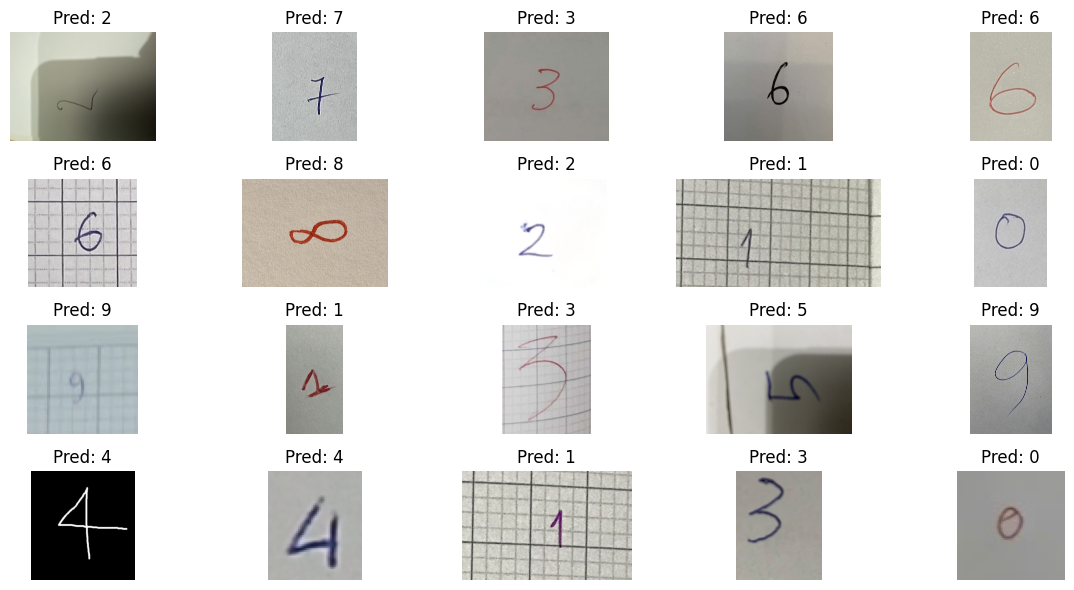

In [13]:
# Định nghĩa thư mục test
test_folder = "/kaggle/input/handwritten-test-10k"

# Thiết bị (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Định nghĩa transform cho test (tương tự 'val')
transform = data_transforms['val']
# Lấy 20 ảnh ngẫu nhiên từ thư mục test
all_files = [f for f in os.listdir(test_folder)]
random.shuffle(all_files)
selected_files = all_files[:20]

# Chuyển mô hình sang chế độ đánh giá
model.eval()

# Tạo figure để plot
plt.figure(figsize=(12, 6))

# Test và plot từng ảnh
for i, filename in enumerate(selected_files):
    # Đọc ảnh
    img_path = os.path.join(test_folder, filename)
    image = Image.open(img_path).convert("RGB") # Đọc ảnh và chuyển thành grayscale

    # Áp dụng transform
    image_input = transform(image).unsqueeze(0).to(device)  # Thêm chiều batch và chuyển sang device

    # Dự đoán
    with torch.no_grad():
        outputs = model(image_input)
        _, predicted = torch.max(outputs, 1)
        pred_label = predicted.item()

    # Plot ảnh
    plt.subplot(4, 5, i + 1)
    plt.imshow(image, cmap="gray")  # Hiển thị ảnh gốc (grayscale)
    plt.title(f"Pred: {pred_label}")
    plt.axis("off")

# Điều chỉnh layout và hiển thị
plt.tight_layout()
plt.show()

In [14]:
what_news = """
-VGG16
- config: scheduler, transform, optim
---> Full finetune
- 10eps

- ** save at: VGG16/full_finetune
"""